# Auxiliary functions

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage import io, color
import pickle
import copy

def unpickle(file):
    
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict[b"data"]

In [3]:
def printdata(data):
    
    plt.imshow(data[5], cmap='gray')

# U-Net

In [4]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        #Convolution and deconvolution
        self.conv1 = nn.Conv2d(1, 12, (4, 4), stride=2, padding=1)
        self.conv2 = nn.Conv2d(12, 24, (4, 4), stride=2, padding=1)
        self.conv3 = nn.Conv2d(24, 48, (4, 4), stride=2, padding=1)
        self.conv4 = nn.Conv2d(48, 96, (4, 4), stride=2, padding=1)
        #self.conv5 = nn.Conv2d(3, 3, (4, 4), stride=2, padding=1)
        self.deconv1 = nn.ConvTranspose2d(96, 48, (4, 4), stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(96, 24, (4, 4), stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(48, 12, (4, 4), stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(24, 6, (4, 4), stride=2, padding=1)
        self.conv5 = nn.Conv2d(6, 3, (1, 1))
        
        #Batchnorm
        self.conv1_bnorm = nn.BatchNorm2d(12)
        self.conv2_bnorm = nn.BatchNorm2d(24)
        self.conv3_bnorm = nn.BatchNorm2d(48)
        self.conv4_bnorm = nn.BatchNorm2d(96)
        
        self.deconv1_bnorm = nn.BatchNorm2d(48)
        self.deconv2_bnorm = nn.BatchNorm2d(24)
        self.deconv3_bnorm = nn.BatchNorm2d(12)
        self.deconv4_bnorm = nn.BatchNorm2d(6)
    
    def forward(self, x32):
        # Contraction
        x16 = F.leaky_relu(self.conv1(x32), 0.2)
        x16 = self.conv1_bnorm(x16)
        
        x8 = F.leaky_relu(self.conv2(x16), 0.2)
        x8 = self.conv2_bnorm(x8)
        
        x4 = F.leaky_relu(self.conv3(x8), 0.2)
        x4 = self.conv3_bnorm(x4)
        
        x2 = F.leaky_relu(self.conv4(x4), 0.2)
        x2 = self.conv4_bnorm(x2)
        
        
        # Expansion
        x = F.relu(self.deconv1(x2))
        x = self.deconv1_bnorm(x)
        x4 = torch.cat((x,x4), 1)
        
        x = F.relu(self.deconv2(x4))
        x = self.deconv2_bnorm(x)
        x8 = torch.cat((x,x8), 1)
        
        x = F.relu(self.deconv3(x8))
        x = self.deconv3_bnorm(x)
        x16 = torch.cat((x,x16), 1)
        
        x = F.relu(self.deconv4(x16))
        x = self.deconv4_bnorm(x)
        
        # cross-channel parametric pooling
        # CHECK IF TANH IS A GOOD IDEA???
        x = F.tanh(self.conv5(x))
        #x = self.conv5(x)
        return x
    
net = Unet()
print(net)

Unet(
  (conv1): Conv2d(1, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv1): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2): ConvTranspose2d(96, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3): ConvTranspose2d(48, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4): ConvTranspose2d(24, 6, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(6, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1_bnorm): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_bnorm): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_bnorm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_runnin

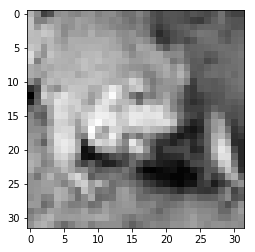

In [9]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# Load training data
train = np.reshape(unpickle('cifar-10-batches-py/data_batch_1'), (10000, 3, 32, 32))
train = np.append(train, np.reshape(unpickle('cifar-10-batches-py/data_batch_2'), (10000, 3, 32, 32)), 0)
train = np.append(train, np.reshape(unpickle('cifar-10-batches-py/data_batch_3'), (10000, 3, 32, 32)), 0)
train = np.append(train, np.reshape(unpickle('cifar-10-batches-py/data_batch_4'), (10000, 3, 32, 32)), 0)
train = np.append(train, np.reshape(unpickle('cifar-10-batches-py/data_batch_5'), (10000, 3, 32, 32)), 0)

# Convert to greyscale and LAB
train_grey = np.zeros((50000, 1, 32, 32))
train_lab  = np.zeros((50000, 3, 32, 32))
for i in range(0, len(train)):
    grey = np.dot(train[i].transpose(1,2,0), [0.299, 0.587, 0.114])
    lab = color.rgb2lab(train[i].transpose(1,2,0)).transpose(2,0,1)
    train_grey[i][0] = grey
    train_lab[i] = lab
# Convert to 0-1 range to avoid tanh fuckery
train_lab = train_lab/100
train_grey = train_grey.transpose(0,2,3,1)/255


# Load test and validation data
testvalid = np.reshape(unpickle('cifar-10-batches-py/test_batch'), (10000, 3, 32, 32))
valid = testvalid[0:9000]
test = testvalid[0:1000]

# Convert to greyscale and lab
valid_grey = np.zeros((9000, 1, 32, 32))
valid_lab = np.zeros((9000, 3, 32, 32))
for i in range(0, len(test)):
    grey = np.dot(valid[i].transpose(1,2,0), [0.299, 0.587, 0.114])
    valid_grey[i][0] = grey
    
    lab = color.rgb2lab(valid[i].transpose(1,2,0)).transpose(2,0,1)
    valid_lab[i] = lab
# Convert to 0-1 range to avoid tanh fuckery
valid_lab = valid_lab/100
valid_grey = valid_grey.transpose(0,2,3,1)/255

# Convert to greyscale
test_grey = np.zeros((1000, 1, 32, 32))
for i in range(0, len(test)):
    grey = np.dot(test[i].transpose(1,2,0), [0.299, 0.587, 0.114])
    test_grey[i][0] = grey
plt.imshow(test_grey[5][0], cmap='gray')
# Convert to 0-1 range to avoid tanh fuckery
test_grey = test_grey.transpose(0,2,3,1)/255

torch.Size([10, 1, 32, 32])
torch.Size([10, 3, 32, 32])
0.08322009444236755 0.07411365956068039
tensor(0.0741, grad_fn=<MseLossBackward>)
0.0867743045091629 0.07163350284099579
tensor(0.0716, grad_fn=<MseLossBackward>)
0.07392366975545883 0.06927218288183212
tensor(0.0693, grad_fn=<MseLossBackward>)
0.07559363543987274 0.06702136248350143
tensor(0.0670, grad_fn=<MseLossBackward>)
0.07065138220787048 0.06485944241285324
tensor(0.0649, grad_fn=<MseLossBackward>)
0.04294029623270035 0.0626407116651535
tensor(0.0626, grad_fn=<MseLossBackward>)
0.07408075034618378 0.06057315692305565
tensor(0.0606, grad_fn=<MseLossBackward>)
0.06640592217445374 0.05856849253177643
tensor(0.0586, grad_fn=<MseLossBackward>)
0.04592129588127136 0.056615132838487625
tensor(0.0566, grad_fn=<MseLossBackward>)
0.0480518601834774 0.05473744496703148
tensor(0.0547, grad_fn=<MseLossBackward>)
0.05082855001091957 0.05293753743171692
tensor(0.0529, grad_fn=<MseLossBackward>)
0.05332333967089653 0.051220010966062546
ten

/afs/inf.ed.ac.uk/user/s18/s1873532/miniconda3/envs/mlp/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 5 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/afs/inf.ed.ac.uk/user/s18/s1873532/miniconda3/envs/mlp/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 7 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/afs/inf.ed.ac.uk/user/s18/s1873532/miniconda3/envs/mlp/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 28 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


(3, 32, 32)
(3, 32, 32)


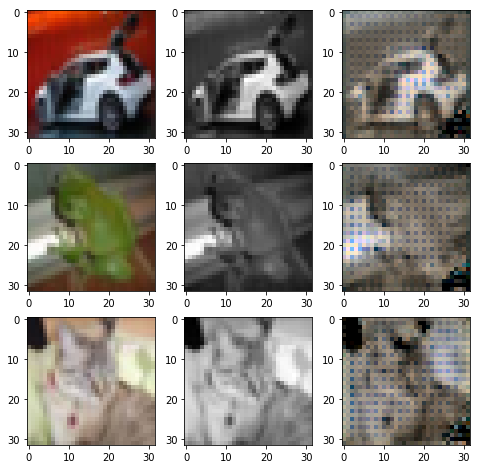

In [11]:
# Load and process the inputs and targets
inputs = torch.tensor(train_grey.transpose(0,3,1,2)).float()
targets = torch.tensor(train_lab).float()

valid_inputs = torch.tensor(valid_grey.transpose(0,3,1,2)).float()
valid_targets = torch.tensor(valid_lab).float()

print(inputs[0:10].shape)
print(targets[0:10].shape)

optimizer = optim.Adam(net.parameters(), lr=0.00002, betas=(0.5,0.999))
#print(list(net.parameters())[0])

bestloss = np.inf
bestmodel = Unet()

for i in range(0,5000):
    input = inputs[i*10:10+i*10]
    target = targets[i*10:10+i*10]
    
    optimizer.zero_grad()   # zero the gradient buffers
    out = net(input)
    criterion = nn.MSELoss()
    loss = criterion(out, target)
    loss.backward()
    optimizer.step()    # Does the update

    #Check if smallest error on validation
    if i%100 == 0:
        out = net(valid_inputs[0:100])
        criterion = nn.MSELoss()
        validloss = criterion(out, valid_targets[0:100])
        print("%s %s" % (str(loss.item()), str(validloss.item())) )
        if validloss.item() < bestloss:
            bestloss = validloss
            bestmodel = copy.deepcopy(net)
            print(bestloss)
    

#print(list(net.parameters())[0])
fig=plt.figure(figsize=(8, 8))
for i in range(0,3):
    fig.add_subplot(3,3,i*3+1)
    print(test[2].shape)
    plt.imshow(test[i+6].transpose(1,2,0))

    fig.add_subplot(3,3,i*3+2)
    plt.imshow(test_grey.transpose(0,3,1,2)[i+6][0], cmap='gray')

    inputs = torch.tensor(test_grey.transpose(0,3,1,2)).float()
    out = bestmodel(inputs[i+6:i+7])
    fig.add_subplot(3,3,i*3+3)
    img = out.detach()[0].numpy().transpose(1,2,0)*100
    plt.imshow(color.lab2rgb(img))

plt.show()
